# How Have Marriages Changed Over the Years?

Our client is a dating coach, and she the same question about her country's marriage trends and wished to gain more insight how it could impact her clients.

For our clients we will explore how the following
1. The Crude Marriage Rate (CRM) A look at a population's general inclinations toward getting married
2. The average age of the bride and groom at first marriage to how late or early in adulthood people are marrying
3. And the age group of first marriage, for a detailed look at what ages are the most common for men and women, and if there is a trend in delaying marriage. 

Analyzing these trends will reveal the people's expectation and preferences when it comes to planning out their relationships.

## What Data Do We Have At out Disposal?
Our our explorations we have pulled data from two sources: 
1. [Eurostat](https://ec.europa.eu/eurostat/web/main/home) - Provides and harmonizes statistics across member states of the European Union
2. [BDL](https://bdl.stat.gov.pl/bdl/start) - The Local Data Bank (BDL). Poland's largest database for national metrics

From BDL
- *Marriages Contracted by Age of Newlyweds* - Provides the age grouping of men and women at time of marriage
- *Marriages Contracted by Year* - The year and total marriages
- *Poland Population* - Total Population of the country from 2005

From Eurostat
- *Eu CMR* - Provides the European Union's crude marriage rate
- *Marriage by Singular Age* - Provides the total number of marriages for each age of both groom and bride for each year
 

## Loading the Data

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [55]:
df_female = pd.read_csv('data/bride age group.csv', sep=';')
df_male = pd.read_csv('data/groom age group.csv', sep=';')
df_total_marriages = pd.read_csv('data/marriages_contracted_per_year.csv', sep=';')
# df_pop = pd.read_csv('data/poland_population.csv', sep=';') 
df_pop = pd.read_csv('data/poland_population_2005.csv', sep=';') 
# df_eu_cmr = pd.read_csv('data/tps00206 EU and Poland Crude Marraige Rate.csv')
df_eu_cmr = pd.read_csv('data/tps00206 EU CMR 2001.csv')
# df_ama_female = pd.read_csv('data/tps00014 Mean Female Age at Marriage.csv')
# df_ama_male = pd.read_csv('data/tps00014 Mean Male Age at Marriage.csv')
df_sing_age = pd.read_csv('data/poland_marriages_by_age_gender_year.csv')

plt.style.use('./assets/executive_report.mplstyle')

## Data Wrangling

Our first task is to clean and transform the data to perform our analysis.

### Marriages by Age Group

In [56]:
# Denoting sex for each
df_female['sex'] = 'female'
df_male['sex'] = 'male'

# Dropping the rows representing total marriages regardless of age group 
df_female = df_female[df_female['Age of females'] != 'females total']
df_male = df_male[df_male['Age of males'] != 'males total']

# Dropping counterpart age of female and age of male columns
df_female.drop(columns='Age of males', inplace=True)
df_male.drop(columns='Age of females', inplace=True)

# Rename to age group
df_female.rename(columns={'Age of females' : 'age group'}, inplace=True)
df_male.rename(columns={'Age of males' : 'age group'}, inplace=True)

# print(df_female.head())
# print(df_male.head())

In [57]:
# Concatenating and renaming the columns
df_marriage = pd.concat([df_male, df_female], axis=0)
df_marriage.drop(
    columns=['Code','Name', 'Location', 'Types of marriages', 'Measure Unit', 'Attribute', 'Unnamed: 10'],
    inplace=True)

del(df_female, df_male)
df_marriage.head(5)

,age group,Year,Value,sex
14,under 20 years,2010,1320,male
15,under 20 years,2011,1090,male
16,under 20 years,2012,911,male
17,under 20 years,2013,716,male
18,under 20 years,2014,619,male


Our client specified that she had a focus on people dating in their early adulthood to late 30's, so we will group all ages past 40 into a single age group. 

In [58]:
new_age_dict = {
    'under 20 years' : '<20',
    '40-49' : '+40',
    '50-59' : '+40',
    '60 and more' : '+40'
}

df_marriage['age group'].replace(new_age_dict, inplace= True)
df_marriage = df_marriage.groupby(['Year', 'sex', 'age group'])['Value'].sum().reset_index()

df_marriage.head(6)

,Year,sex,age group,Value
0,2010,female,+40,13816
1,2010,female,20-24,79746
2,2010,female,25-29,89646
3,2010,female,30-34,26972
4,2010,female,35-39,9150
5,2010,female,<20,9007


To aid us, we will compute the percentage of the total of marriages that each age group contributes and the age groups rank, to indicate the order in which age group contributes to total marriages that year.

In [59]:
df_marriage['% of total'] = df_marriage['Value'] / df_marriage.groupby(['Year','sex'])['Value'].transform('sum')
df_marriage['rank'] = df_marriage.groupby(['Year','sex'])['Value'].rank(ascending=False)
df_marriage.head(12)


,Year,sex,age group,Value,% of total,rank
0,2010,female,+40,13816,0.060507,4.0
1,2010,female,20-24,79746,0.349247,2.0
2,2010,female,25-29,89646,0.392604,1.0
3,2010,female,30-34,26972,0.118124,3.0
4,2010,female,35-39,9150,0.040072,5.0
5,2010,female,<20,9007,0.039446,6.0
6,2010,male,+40,20041,0.087769,4.0
7,2010,male,20-24,44683,0.195689,2.0
8,2010,male,25-29,103417,0.452914,1.0
9,2010,male,30-34,44104,0.193153,3.0


In [60]:
# figure, axes = plt.subplots(2,1)
# plt.figure(figsize=(10,8))

# for i, sex in enumerate(df_marriage['sex'].unique()):
#     dt_temp = df_marriage[df_marriage['sex'] == sex]
#     sns.lineplot(dt_temp, x='Year', y='Value', ax=axes[i], hue='age group')

In [61]:
# figure, axes = plt.subplots(2,1)
# plt.figure(figsize=(10,8))

# for i, sex in enumerate(df_marriage['sex'].unique()):
#     dt_temp = df_marriage[df_marriage['sex'] == sex]
#     sns.lineplot(dt_temp, x='Year', y='% of total', ax=axes[i], hue='age group')

In [62]:
# figure, axes = plt.subplots(2,1)
# plt.figure(figsize=(10,8))

# for i, sex in enumerate(df_marriage['sex'].unique()):
#     dt_temp = df_marriage[(df_marriage['sex'] == sex) & (df_marriage['age group'] != '<20') ]
#     sns.lineplot(dt_temp, x='Year', y='rank', ax=axes[i], hue='age group')
#     axes[i].invert_yaxis()  # Invert the y-axis for the specific axes


### Total Marriages by Year

In [63]:
df_total_marriages = df_total_marriages.loc[:, ['Year','Value']]
df_total_marriages.head(5)

,Year,Value
0,1995,207081
1,1996,203641
2,1997,204850
3,1998,209430
4,1999,219398


In [64]:

# plt.figure(figsize=(10,6))

# # ----- Axis Setup ----- #
# ax1 = plt.gca()
# # ax2 = ax1.twinx()

# # ----- Plots ----- #
# sns.lineplot(df_total_marriages, x='Year', y='Value', label='Total Marriages', ax=ax1)
# # sns.lineplot(df_ama[df_ama['sex'] == 'male'], x ='year', y ='ave_age', label= 'Ave Age of Groom', ax=ax2, linestyle='--')
# # sns.lineplot(df_ama[df_ama['sex'] == 'female'], x ='year', y ='ave_age',label= 'Ave Age of Bride', ax=ax2, linestyle=':')
# # sns.lineplot(weighted_avg_df[weighted_avg_df['sex'] == 'M'], x ='TIME_PERIOD', y ='Weighted_Ave_Age', label= 'Ave Age of Groom', ax=ax2, linestyle='--')
# # sns.lineplot(weighted_avg_df[weighted_avg_df['sex'] == 'F'], x ='TIME_PERIOD', y ='Weighted_Ave_Age', label= 'Ave Age of Bride', ax=ax2, linestyle=':')

# # ----- Title Formatting ---- #
# plt.title('Marriage Rates been heavily influenced by economic factors', loc='left', ha='left')

# # ----- Axis Formatting ----- #
# ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}K'.format(y/1000)))
# ax1.set_ylabel(ylabel='Number of Marriages')
# # ax2.set_ylabel(ylabel='Age of Marriage')

# ax1.grid(False)
# # ax2.grid(False)

# # ----- Legend Formatting ----- #
# lines_1, labels_1 = ax1.get_legend_handles_labels()
# # lines_2, labels_2 = ax2.get_legend_handles_labels()
# # ax2.get_legend().remove()
# # ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.1, 1))

# plt.show()

### Total Population

In [65]:
df_pop = df_pop[['Year', 'Value']].dropna(axis=0, how='any')
df_pop.head(5)

,Year,Value
0,2005,38157055.0
1,2006,38125479.0
2,2007,38115641.0
3,2008,38135876.0
4,2009,38167329.0


### Poland's Crude Marriage Rate


In [66]:

df_cmr = pd.merge(df_total_marriages, df_pop, on='Year', how='outer')
df_cmr = df_cmr.dropna().reset_index(drop=True)

df_cmr.columns = ['year', 'marriages', 'population']
df_cmr['cmr'] = (df_cmr['marriages'] / df_cmr['population'] * 1000).round(1)
df_cmr.drop(columns=['marriages', 'population'], inplace=True)

df_cmr.head(10)

,year,cmr
0,2005,5.4
1,2006,5.9
2,2007,6.5
3,2008,6.8
4,2009,6.6
5,2010,5.9
6,2011,5.4
7,2012,5.3
8,2013,4.7
9,2014,4.9


### EU's Crude Marriage Rate

In [67]:
df_eu_cmr = df_eu_cmr[df_eu_cmr['geo'] == 'EU27_2020']
df_eu_cmr = df_eu_cmr.loc[:, ['TIME_PERIOD', 'OBS_VALUE']]
df_eu_cmr.columns = ['year', 'cmr eu']
df_eu_cmr.head(10)

,year,cmr eu
0,2001,4.9
1,2002,4.9
2,2003,4.8
3,2004,4.8
4,2005,4.8
5,2006,4.8
6,2007,5.0
7,2008,4.8
8,2009,4.6
9,2010,4.4


In [68]:
df_cmr = pd.merge(df_cmr, df_eu_cmr, on='year', how='outer')

del(df_eu_cmr)

df_cmr = df_cmr.sort_values('year').reset_index(drop=True)
df_cmr.head(10)

,year,cmr,cmr eu
0,2001,NaN,4.9
1,2002,NaN,4.9
2,2003,NaN,4.8
3,2004,NaN,4.8
4,2005,5.4,4.8
5,2006,5.9,4.8
6,2007,6.5,5.0
7,2008,6.8,4.8
8,2009,6.6,4.6
9,2010,5.9,4.4


### Ave Age of First Marriage

To get an accurate number for the average age at time of marriage, we will compute the weighted average using the number of marriages contracted at each age. Other datasets have this information already formatted, but often start at 2011 only. using this method we can get the same metric starting from 1995.

In [69]:
df_sing_age.head(5)

,DATAFLOW,LAST UPDATE,freq,unit,sex,age,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1995,0,NaN
1,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1996,0,NaN
2,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1997,0,NaN
3,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1998,0,NaN
4,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1999,0,NaN


In [70]:
# Correcting 'age' to be an integer
df_sing_age['age'] = df_sing_age['age'].str.lstrip('Y').astype(int)

# Calculating the weighted average
df_avg_age = df_sing_age.groupby(['TIME_PERIOD', 'sex']).apply(
    lambda x: (x['age'] * x['OBS_VALUE']).sum() / x['OBS_VALUE'].sum()
).round(1).reset_index(name='ave age')

df_avg_age.columns = ['year', 'sex', 'ave age']
df_avg_age.replace(to_replace={'F': 'female', 'M':'male'}, inplace=True)

df_avg_age.tail(10)

,year,sex,ave age
46,2018,female,27.5
47,2018,male,29.7
48,2019,female,27.8
49,2019,male,30.0
50,2020,female,28.0
51,2020,male,30.2
52,2021,female,28.2
53,2021,male,30.4
54,2022,female,28.6
55,2022,male,30.8


In [71]:
## Exporting Dataframes for Dash app

if False:
    df_avg_age.to_csv(f'./data/dash_data/average_marriage_age.csv')
    df_cmr.to_csv(f'./data/dash_data/crude_marriage_rate.csv')
    df_marriage.to_csv(f'./data/dash_data/marriage_by_age_group.csv')
    # df_pop.to_csv(f'./data/dash_data/df_.csv')
    df_total_marriages.to_csv(f'./data/dash_data/total_marriages.csv')


## Visualizing the Data

### Crude Marriage Rates

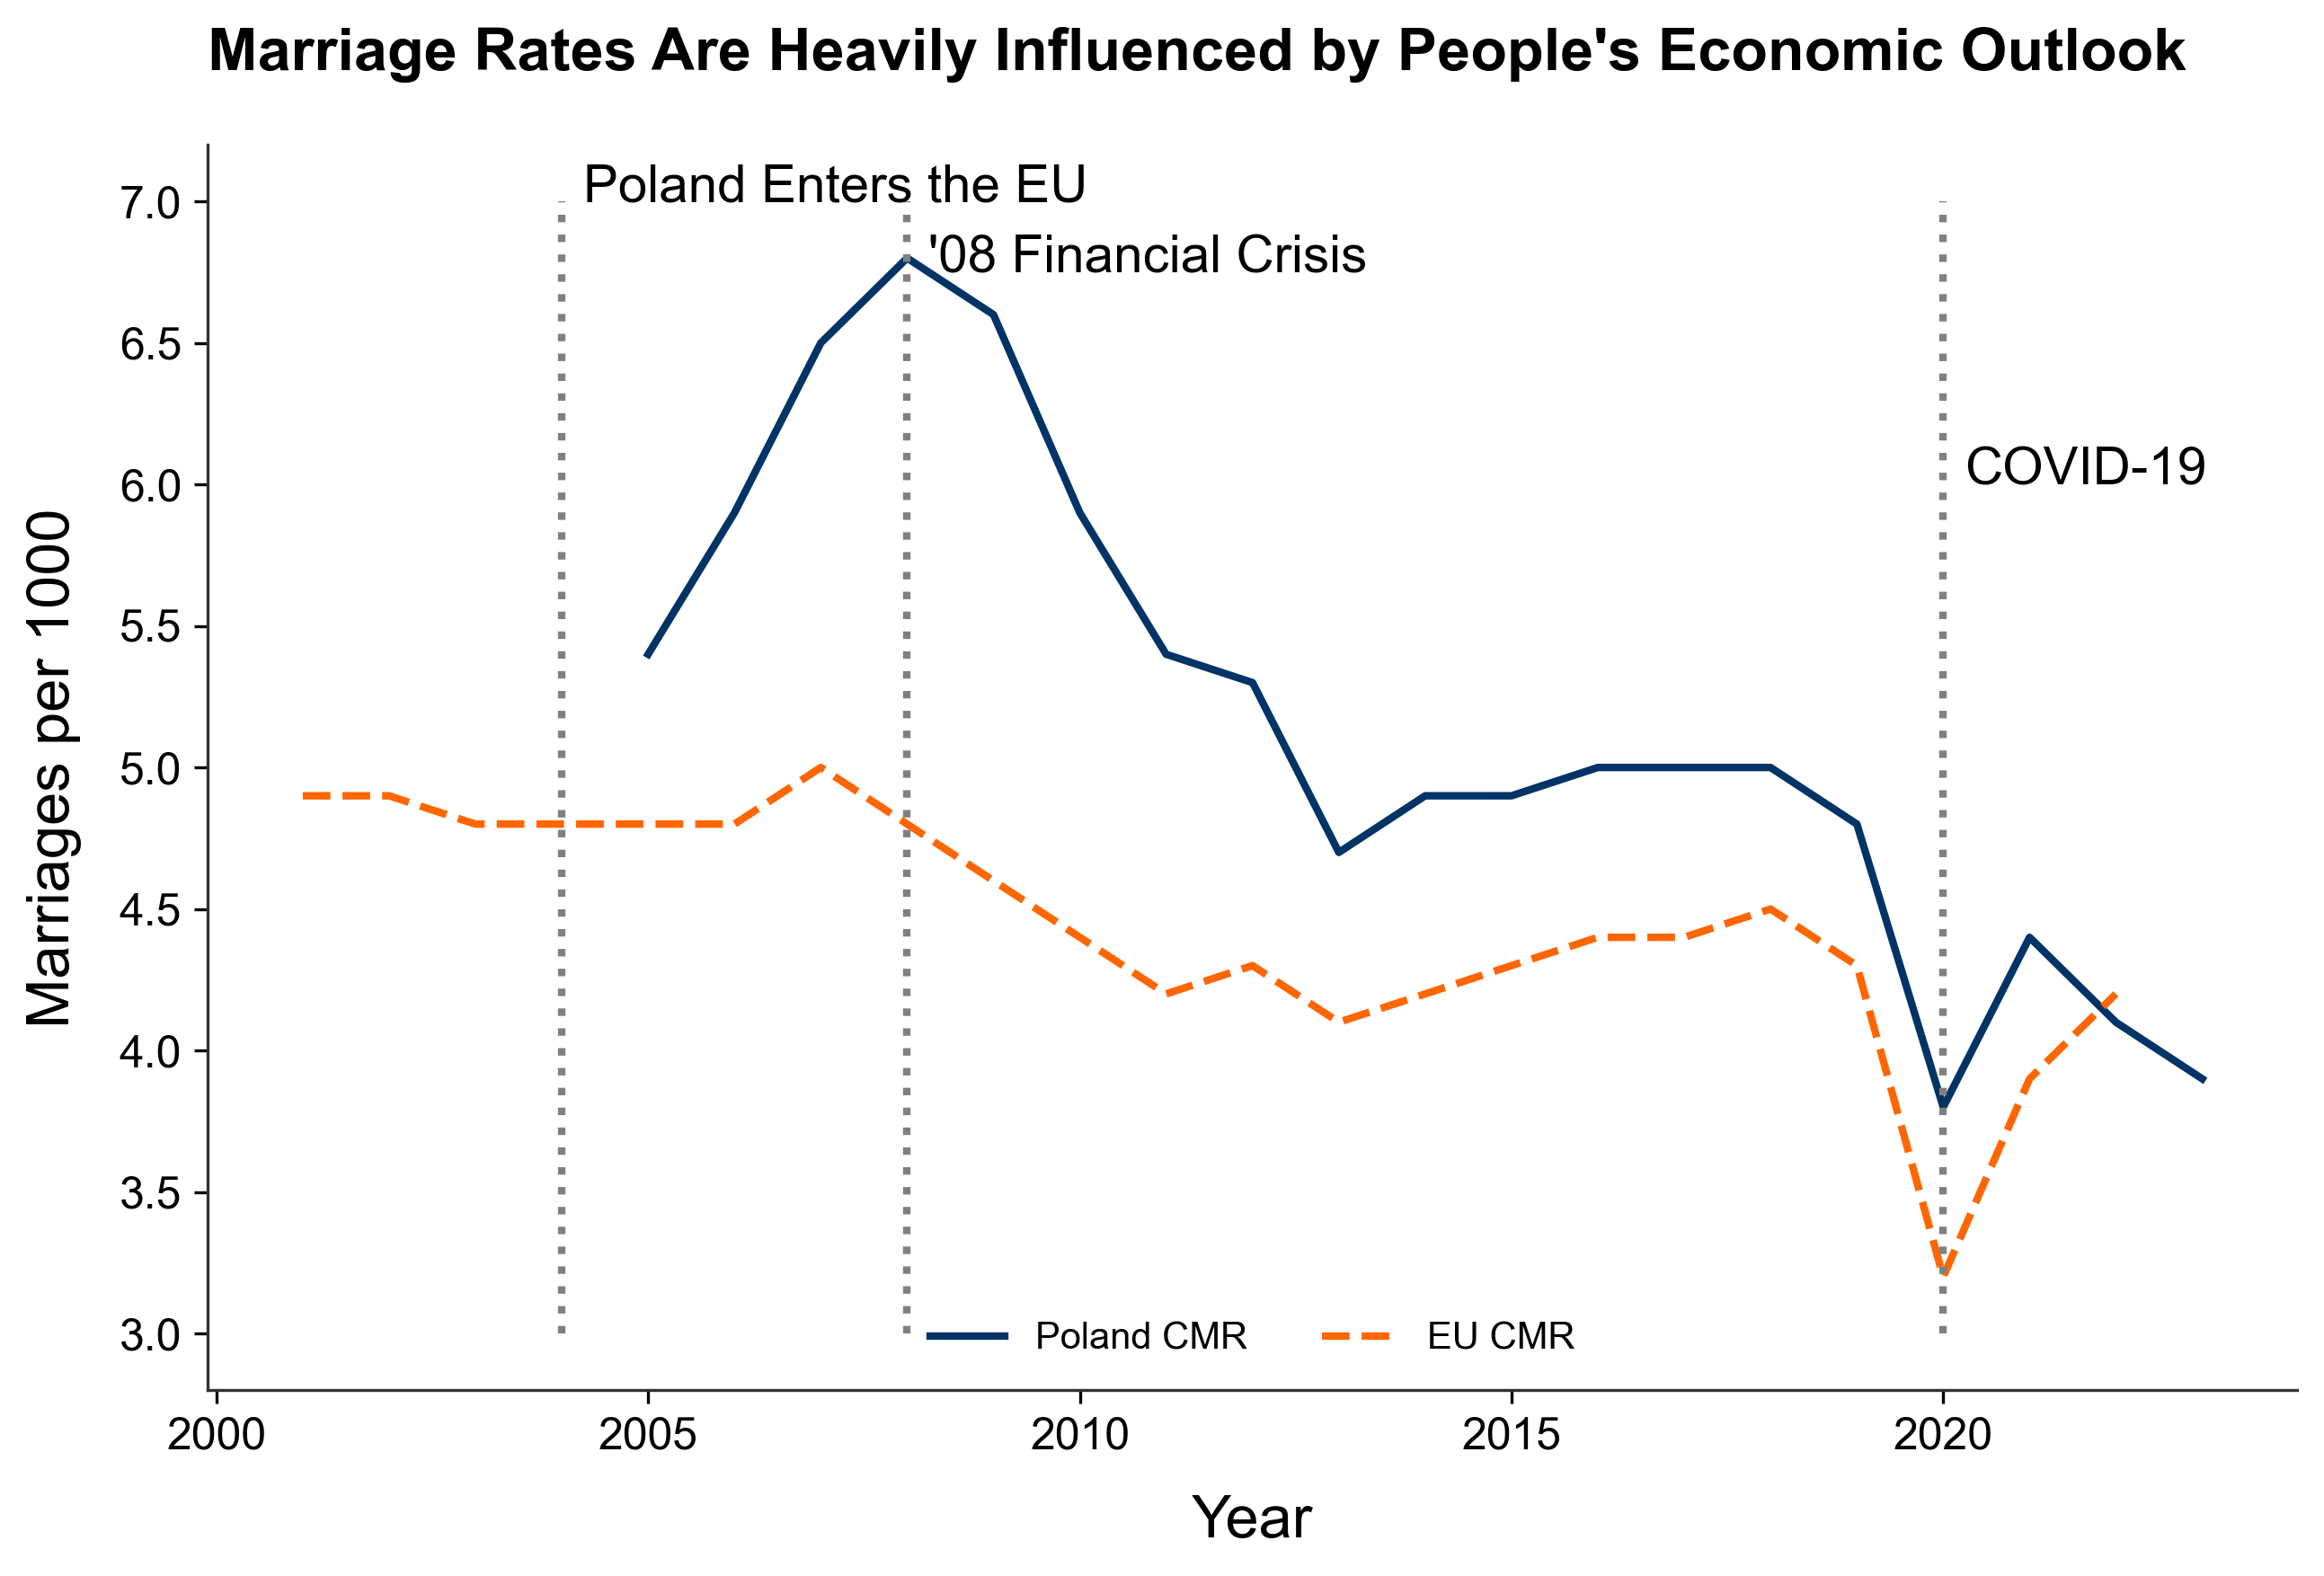

In [72]:

plt.figure(figsize=(10,6))

# ----- Axis Setup ----- #
ax1 = plt.gca()
# ax2 = ax1.twinx()

# ----- Plots ----- #
sns.lineplot(df_cmr, x='year', y='cmr', label='Poland CMR', ax=ax1)
sns.lineplot(df_cmr, x ='year', y ='cmr eu', label= 'EU CMR', ax=ax1, linestyle='--')

# ----- Title Formatting ---- #
plt.title('Marriage Rates Are Heavily Influenced by People\'s Economic Outlook', loc='left', ha='left')
plt.xlabel('Year')
# ----- Axis Formatting ----- #
# ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}K'.format(y/1000)))
ax1.set_ylabel(ylabel='Marriages per 1000')
# ax2.set_ylabel(ylabel='Age of Marriage')

ax1.grid(False)
# ax2.grid(False)

# ----- Legend Formatting ----- #
lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
# ax2.get_legend().remove()
# ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.1, 1))

# Legend
legend = plt.legend(title='', loc='lower center', ncol=len(df_avg_age['sex'].unique()))
legend.get_frame().set_facecolor('none') 
legend.get_frame().set_edgecolor('none') 

events = [[2004,"Poland Enters the EU", 7], [2008,'\'08 Financial Crisis', 6.75], [2020, 'COVID-19', 6.0]]

for event in events:
    plt.vlines(event[0],3,7,'gray',':', label=event[1],)
    plt.text(x = event[0]+.25, y = event[2], s= event[1])

plt.show()

Our chart shows that during times of positive or negative economic outlook, the marriage rates have grown or contracted accordingly. In 2004, Poland was admitted to the European Union with a positive expectation about the benefits it would bring to the national economy. And we can see a sharp increase in marriage rates until 2008.

After 2008, with the Financial Crisis, the marriage rate has been steadily decreasing. Unsurprisingly, we see a sharp drop in 2020, right as the COVID-19 Pandemic it at its highest concern.

Interestingly, Poland faired comparatively well in the 2008 recession, with GDP growth positive, and climbing from 2009 to 2011 <sup>[1](https://tradingeconomics.com/poland/full-year-gdp-growth)</sup>. This is contrasted with the period from 2014 to 2019 GDP where growth was consistently above 3%, and crude marriage rate averaged held steady at 5.0, still above the crude marriage rate of the European Union on average. We can infer two things, positive economic periods may be overshadowed by an individual's perception of economic security not to mention changes in society's attitude towards the important of marriage. This is partially evident, as with time Poland's Crude marriage rate begins to closely match that of the european union as a whole. 


### Average Age of Marriage

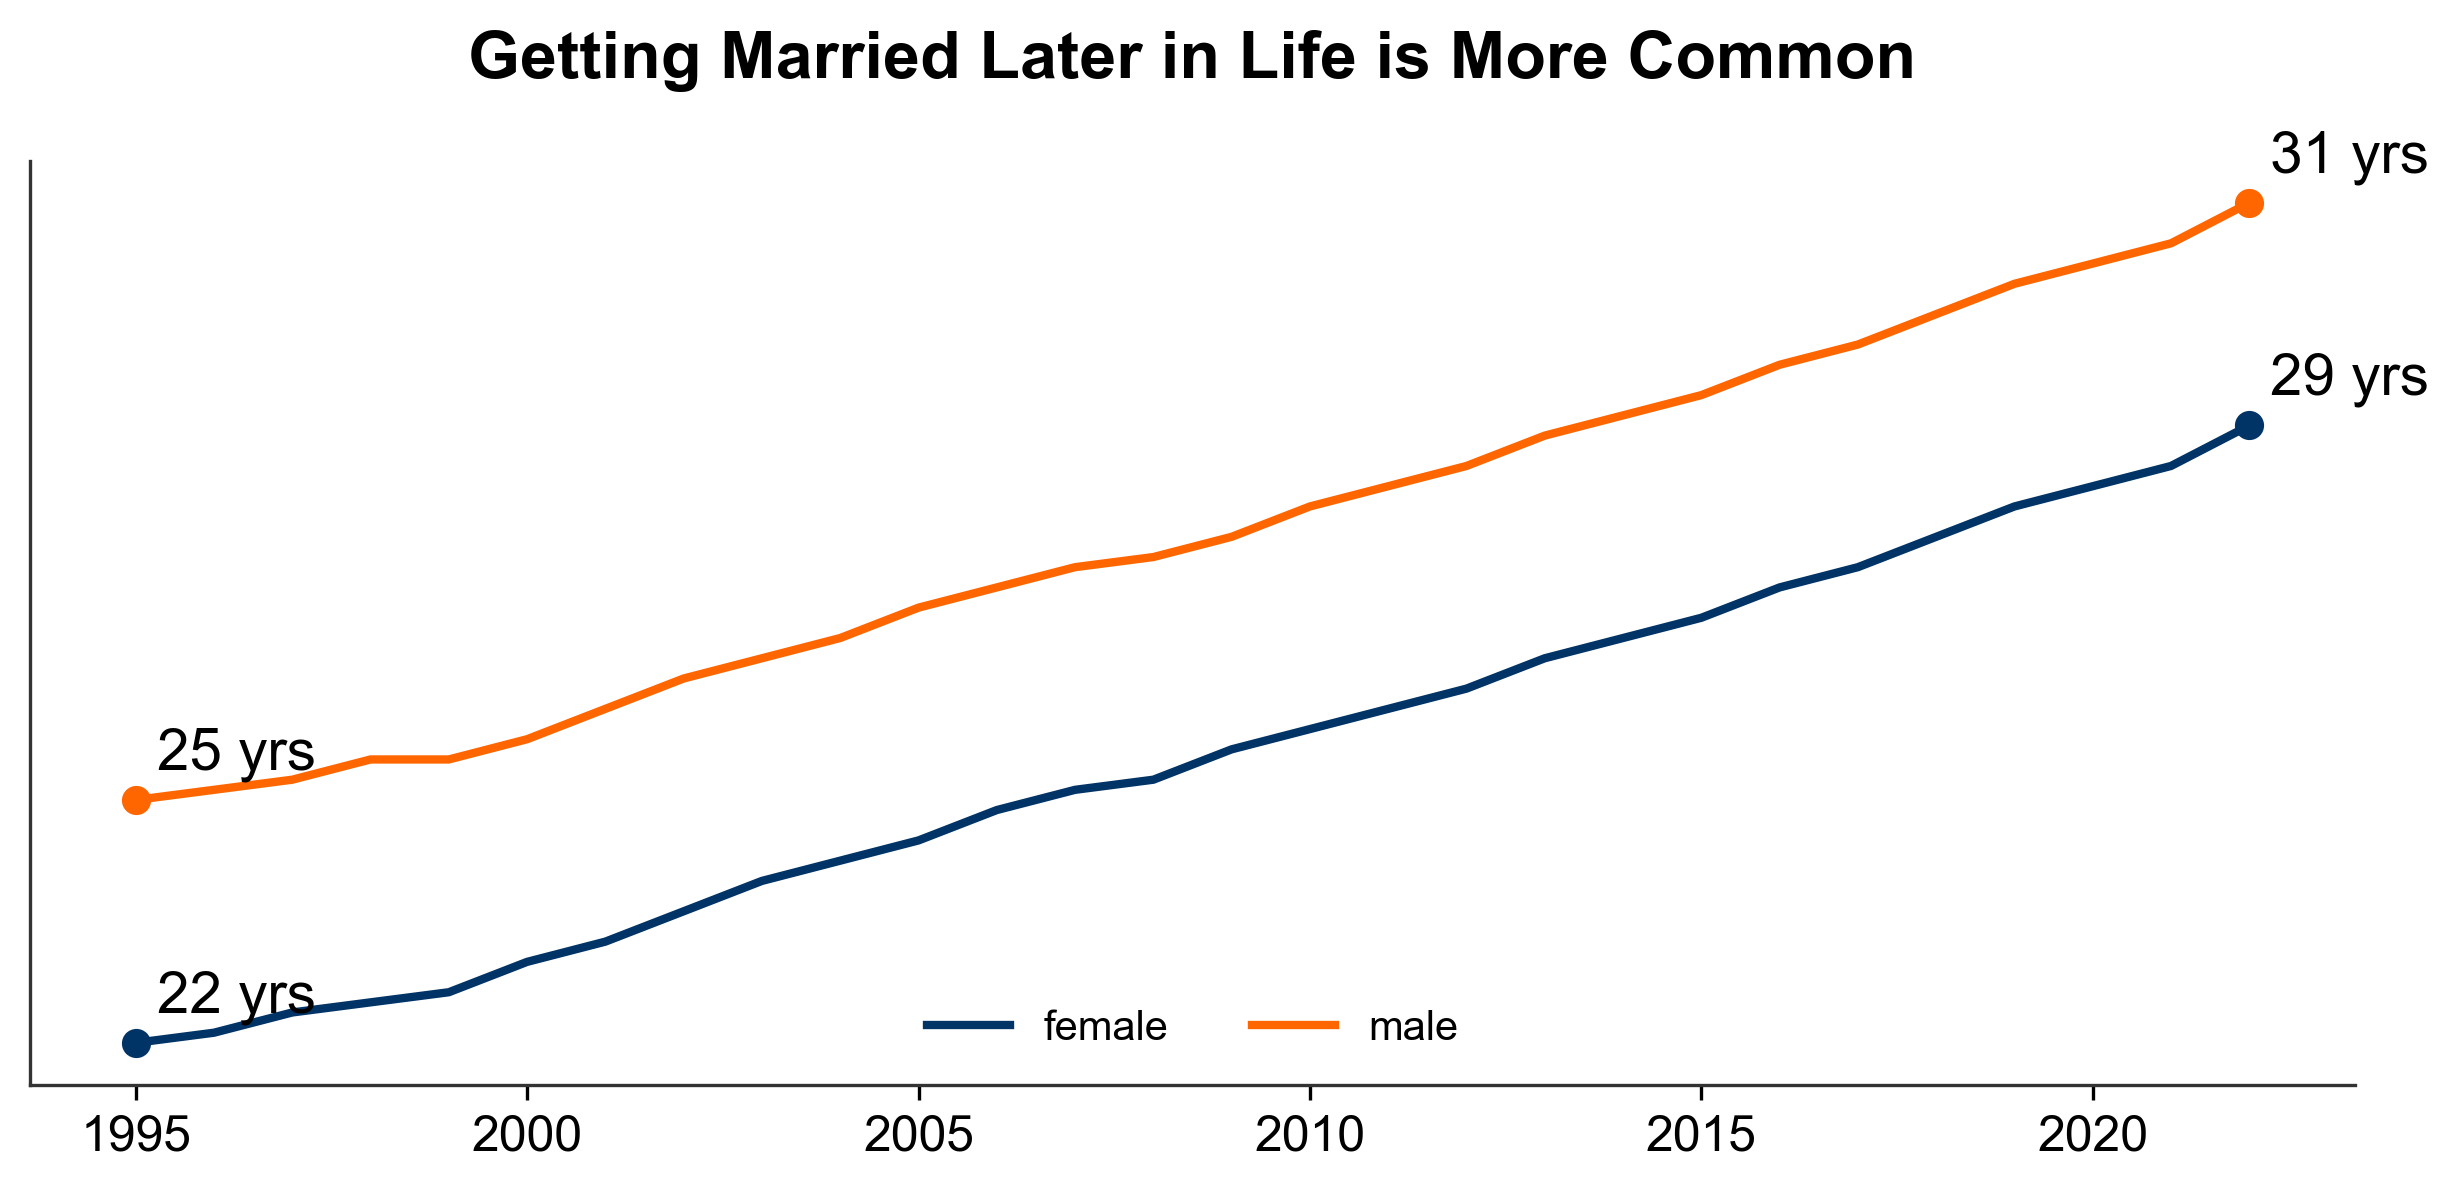

In [73]:
plt.figure(figsize=(10,4))

for sex in df_avg_age['sex'].unique():
    subset = df_avg_age[df_avg_age['sex'] == sex]
    plt.plot(subset['year'], subset['ave age'], label=sex)
    axis = plt.gca()
    axis.yaxis.set_visible(False)

    first_row = subset.iloc[[0]]  # Get the first row
    last_row = subset.iloc[[-1]]  # Get the last row
    # Combine them into a single DataFrame
    df_first_last = pd.concat([first_row, last_row])
    plt.scatter(df_first_last['year'], df_first_last['ave age'])

    for _, row in df_first_last.iterrows():
        text = plt.annotate(f"{row['ave age']:.0f}" + ' yrs',
                        xy = (row['year'], row['ave age']),
                        xytext =(5,11),
                        textcoords ='offset points',
                        ha='left', 
                        va='center',
                        fontsize =14
                        )
        
plt.yticks([])
plt.gca().yaxis.set_visible(False)
# plt.gca().spines['left'].set_visible(False)

# Legend
legend = plt.legend(title='', loc='lower center', ncol=len(df_avg_age['sex'].unique()))
legend.get_frame().set_facecolor('none') 
legend.get_frame().set_edgecolor('none') 

# Labels
plt.xlabel('')
plt.ylabel('Average Age')
plt.title('Getting Married Later in Life is More Common')

plt.show()

A prominent metric for tracking the perception of marriage is the average age of marriage. The general trends in the Western and Developed nations has been for marriages to be postponed until much later in life. Many factors come into play, such the need for establishing financial security, less importance on marriage, or tractional relationships, as well as s perception of the increased cost of having a family. 

For Poland, the trend is no different than what has been observed elsewhere. In fact, the average age for men and women has only creased year over year. With Men getting married 6 years later in life, with women getting married 7 years later in life on average. We will move forward and group teh number of marriages into specific age groups, so get a more granular look at how attitudes towards marriage have changed, and what age groups are becoming more common marriage. 

## Marriages By Age Groups

In [74]:
custom_palette = {
    '<20': 'red',
    '20-24': '#e60049',
    '25-29': '#9b19f5',
    '30-34': "#0bb4ff",
    '35-39': "#ffa300",
    '+40': 'grey'
}

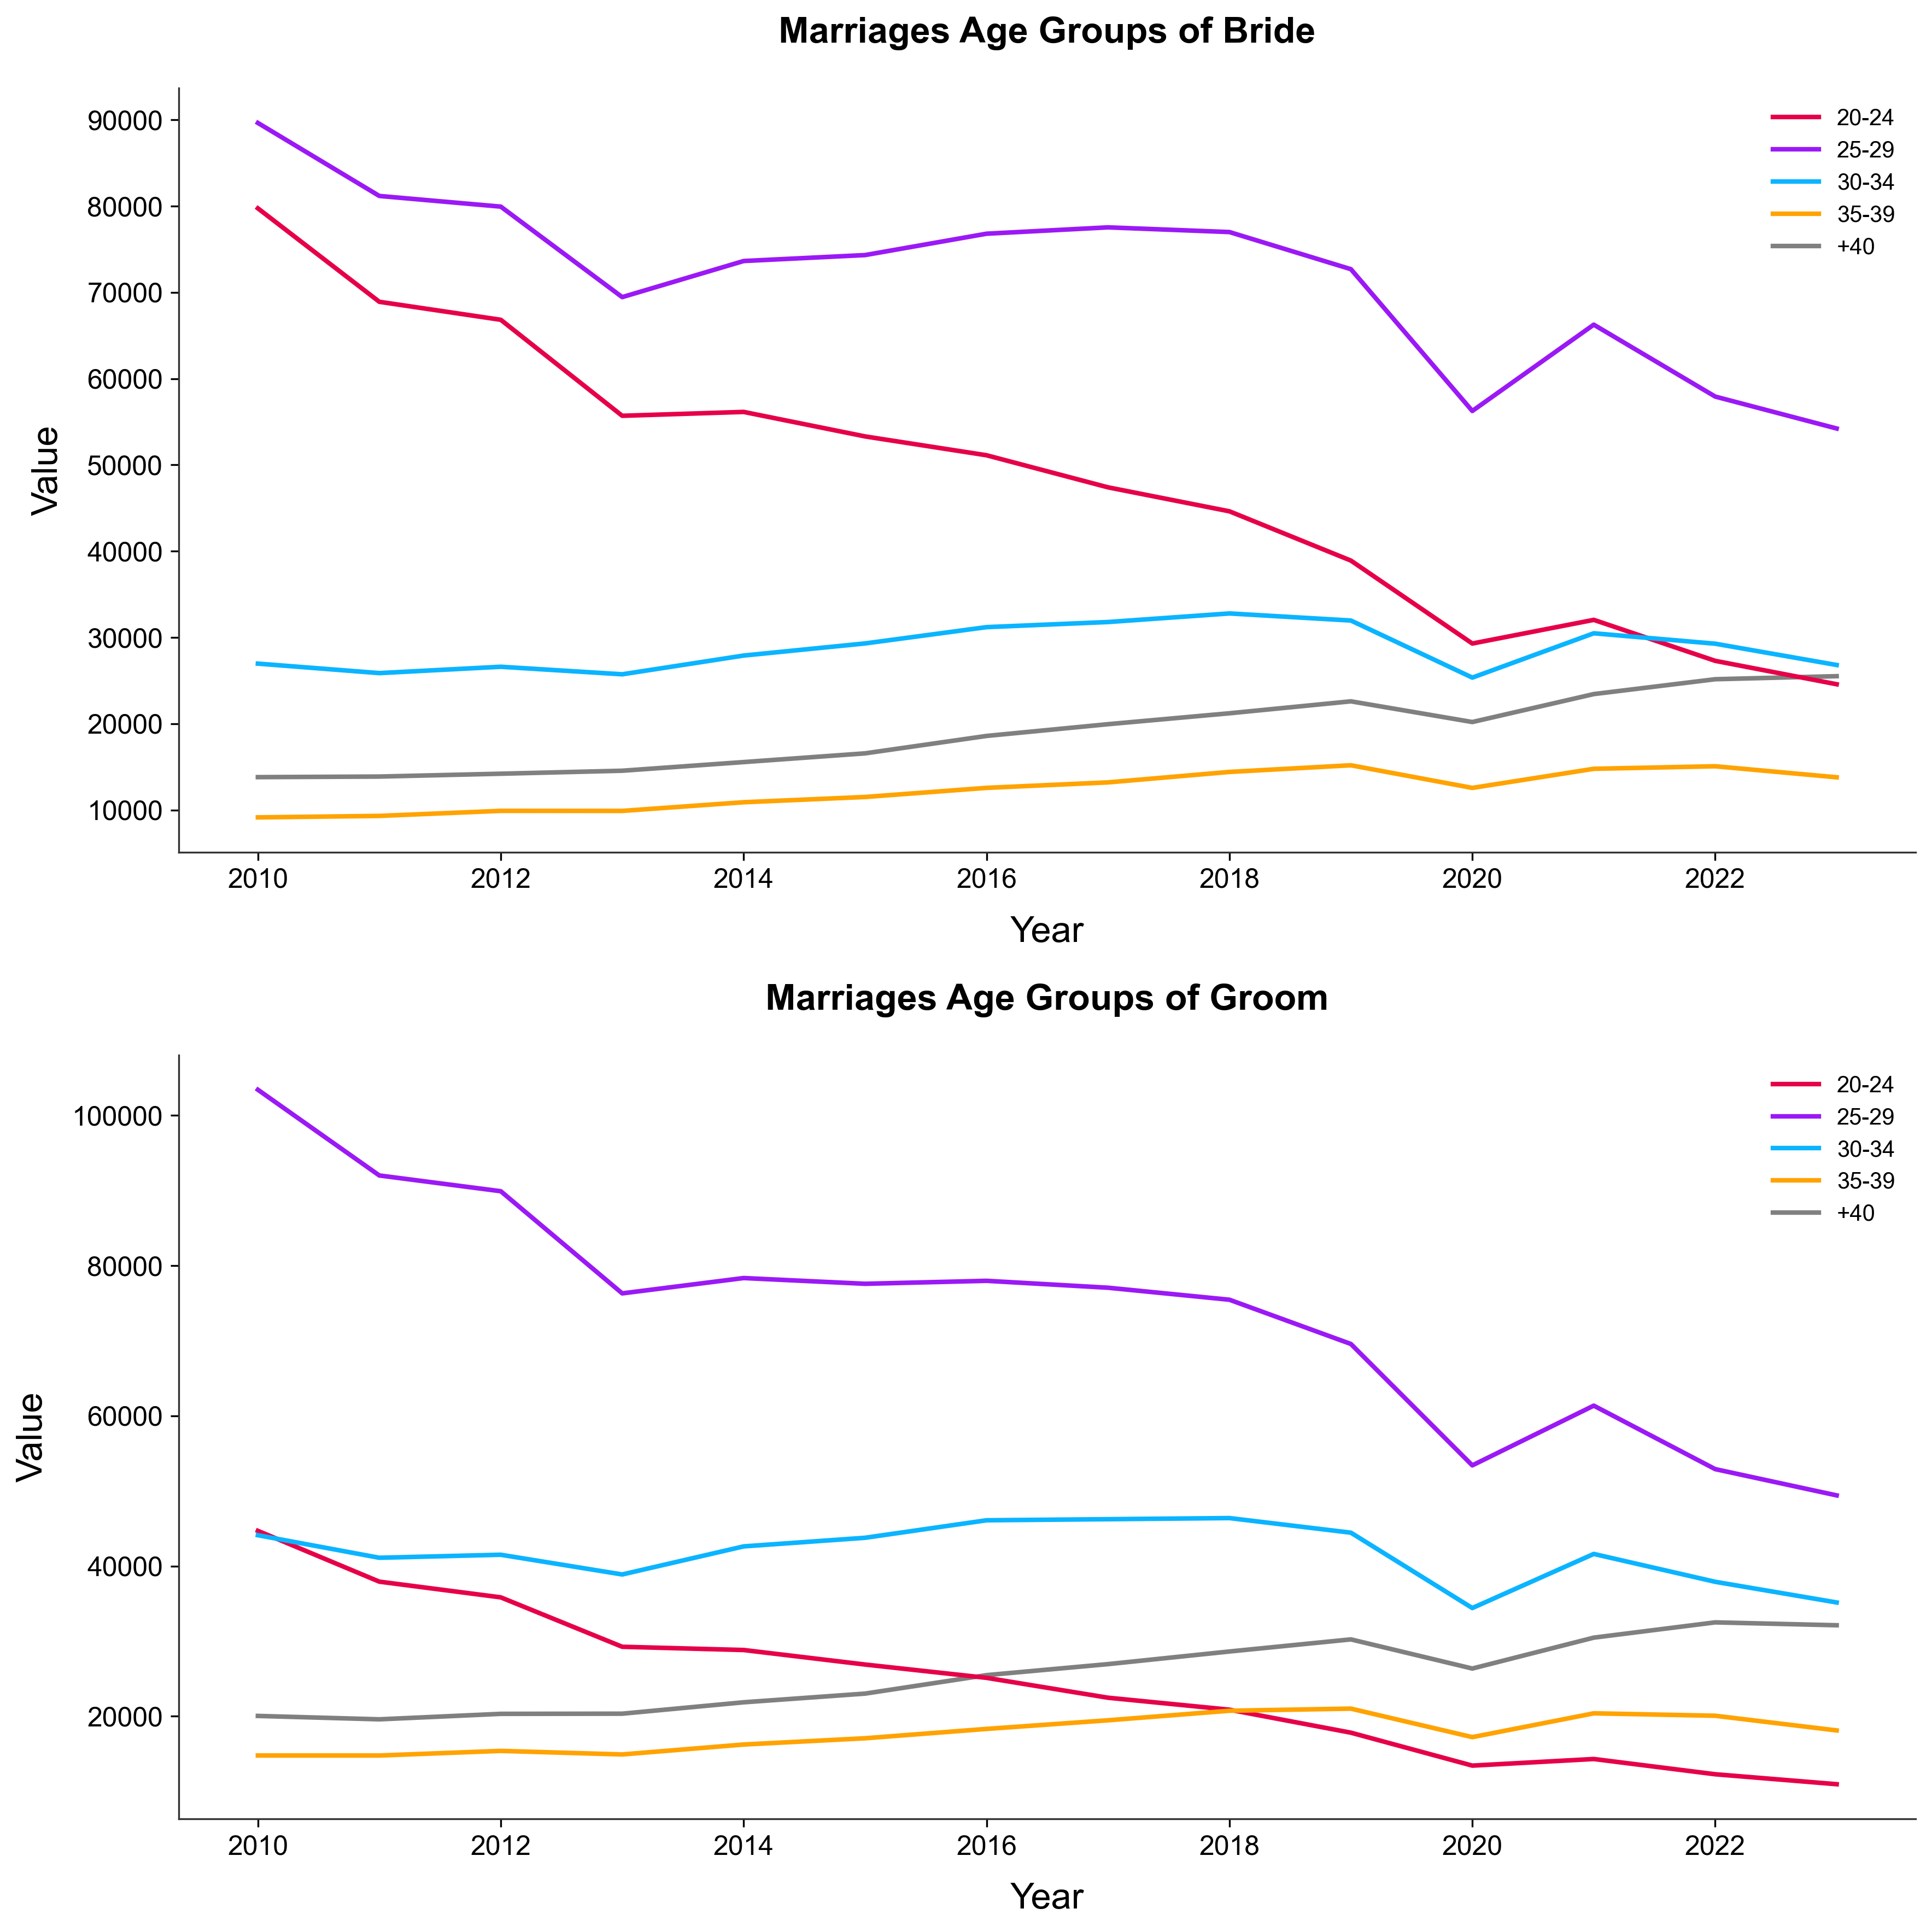

In [75]:
figure, axes = plt.subplots(2, 1, figsize=(12, 12))

for i, sex in enumerate(df_marriage['sex'].unique()):
    dt_temp = df_marriage[(df_marriage['sex'] == sex) & (df_marriage['age group'] != '<20')]
    sns.lineplot(data=dt_temp, x='Year', y='Value', ax=axes[i], hue='age group', palette=custom_palette)
    
    handles, labels = axes[i].get_legend_handles_labels()
    order = [1,2,3,4,0] 
    axes[i].legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    axes[i].set_title(f'Marriages Age Groups of {"Bride" if sex == "female" else "Groom"}')


# Display the plot
plt.tight_layout()
plt.show()

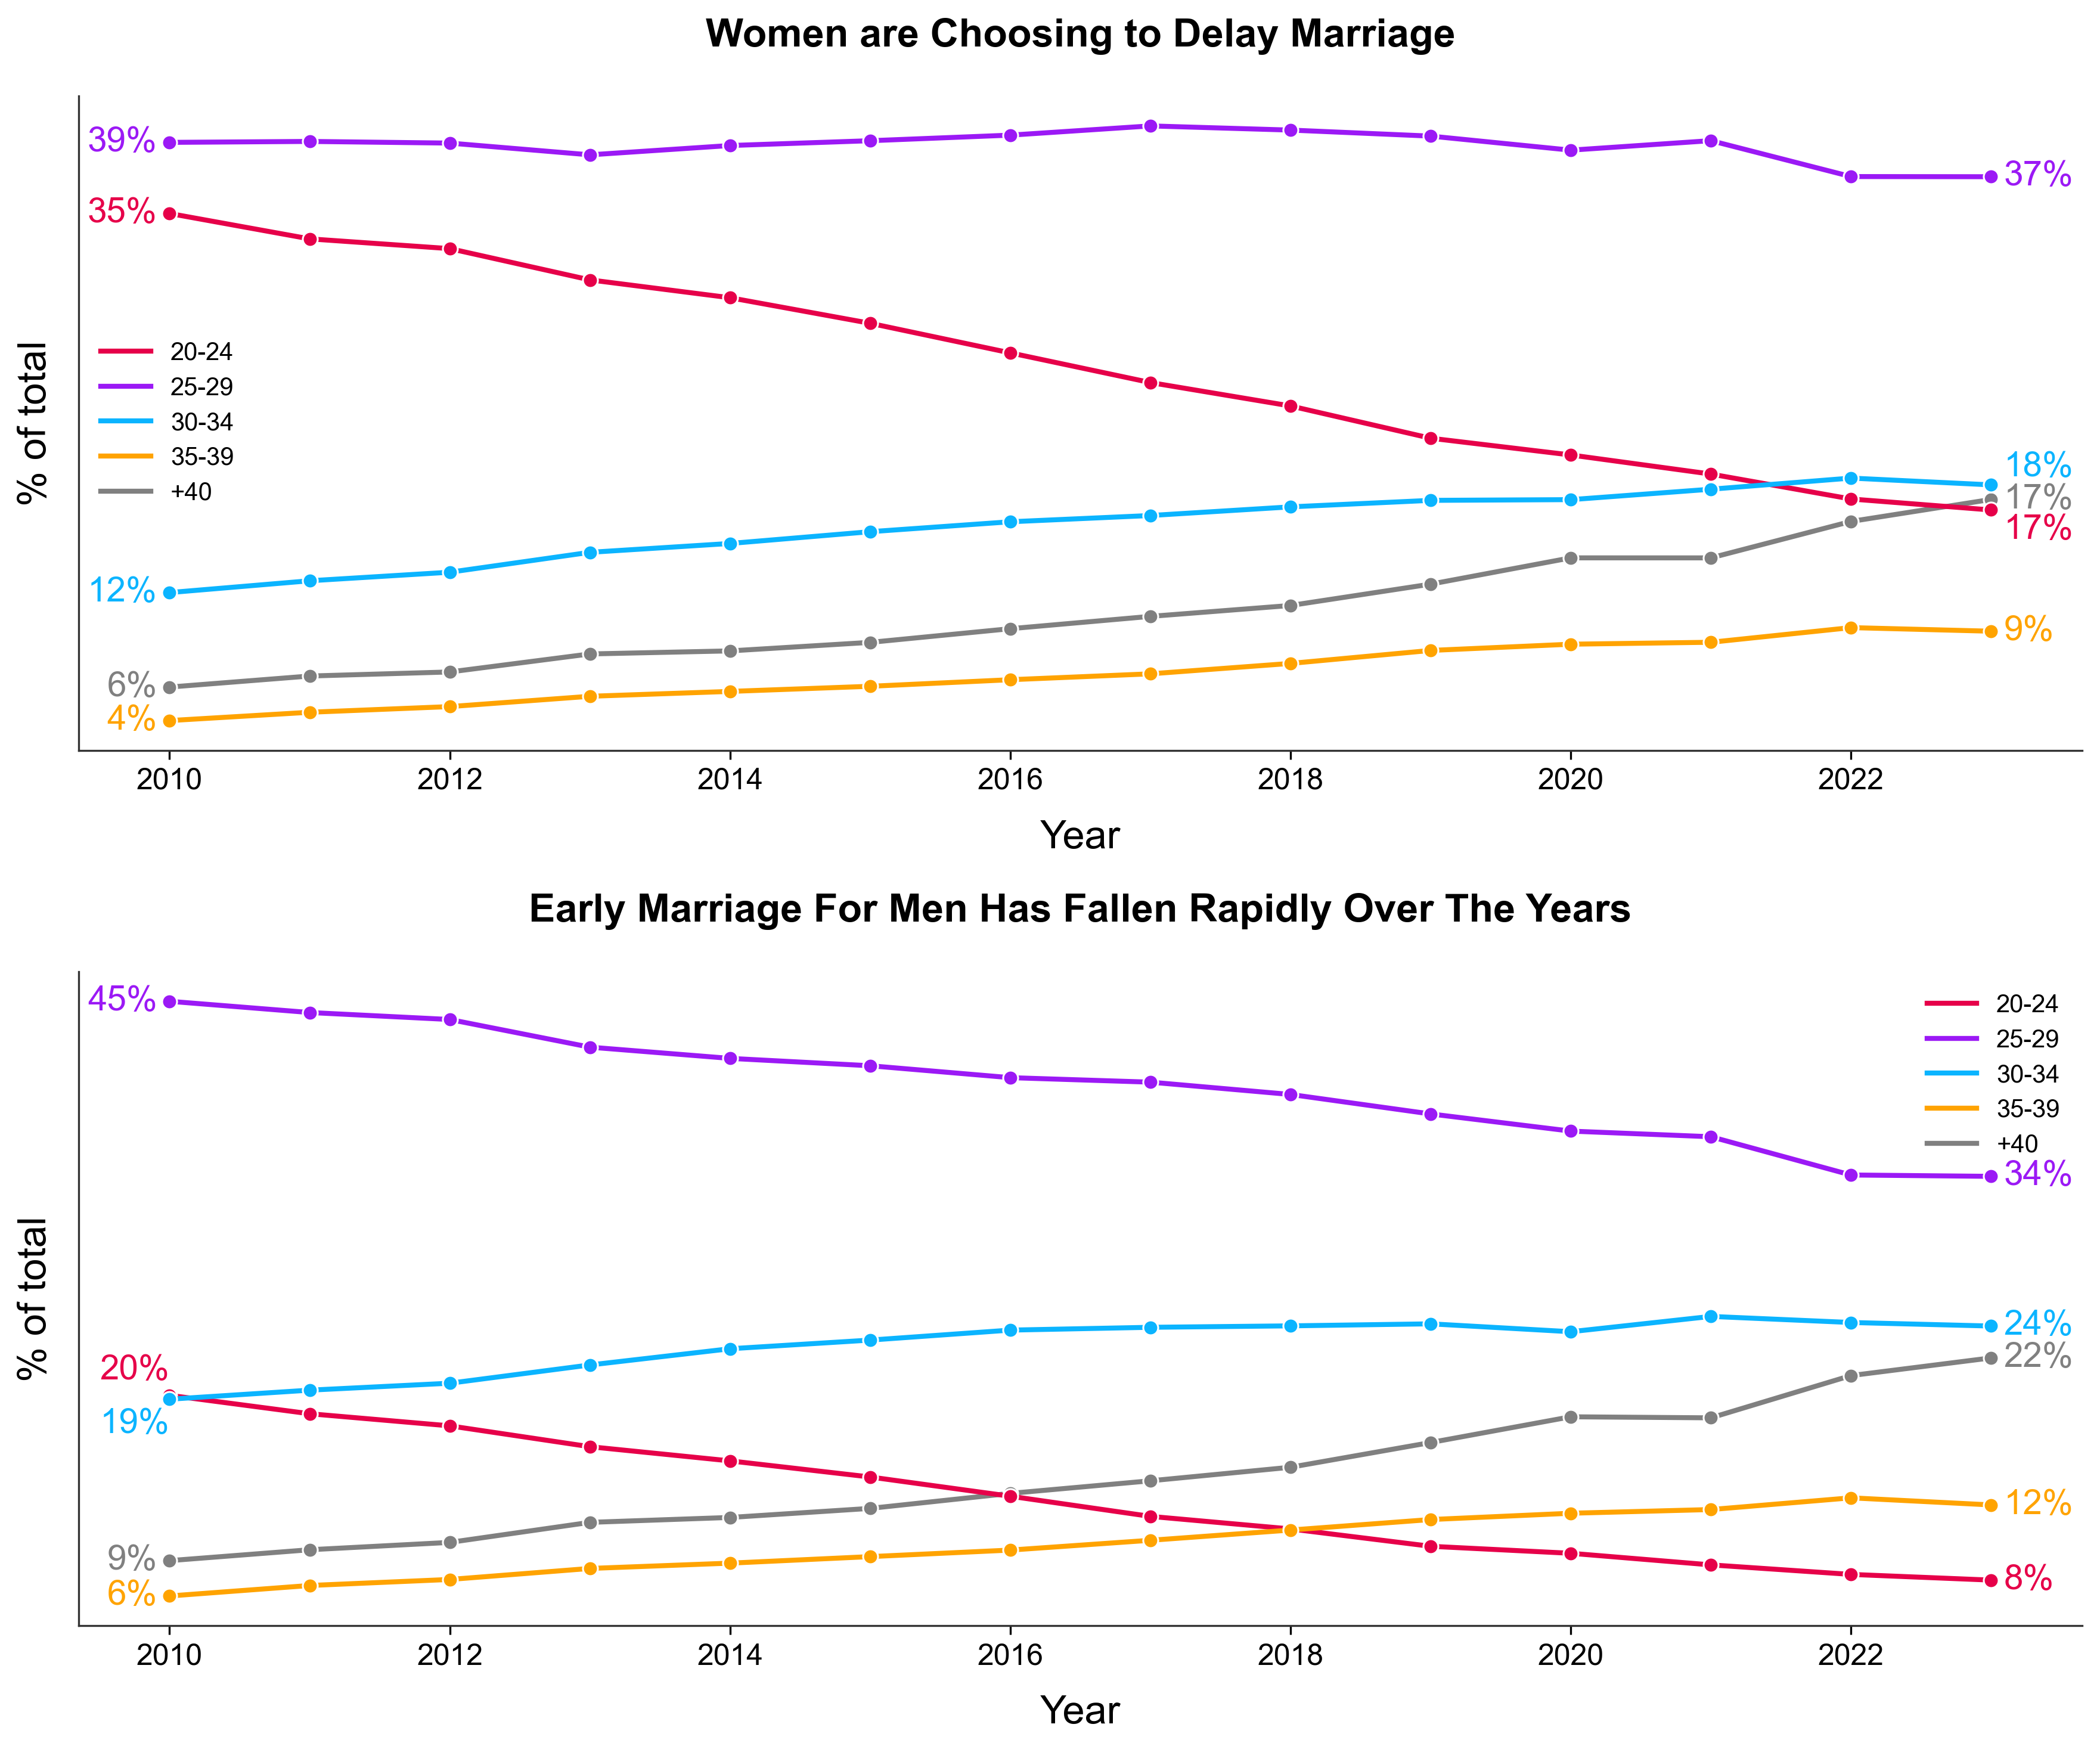

In [76]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
import matplotlib.ticker as mtick

for i, sex in enumerate(df_marriage['sex'].unique()):
    df_temp = df_marriage[(df_marriage['sex'] == sex) & (df_marriage['age group'] != '<20')]

    sns.lineplot(df_temp, x='Year', y='% of total', ax=axes[i], hue='age group', marker='o', palette=custom_palette)

    handles, labels = axes[i].get_legend_handles_labels()
    
    order = [1,2,3,4,0] 
    axes[i].legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    axes[i].set_title(f'{"Women are Choosing to Delay Marriage" if sex == "female" else "Early Marriage For Men Has Fallen Rapidly Over The Years"}')
    axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))  # Assuming 'Value' is in the range [0, 1]
    
    for age_group in df_temp['age group'].unique():

        df_group = df_temp[df_temp['age group'] == age_group]
        last_row = df_group.iloc[-1]
        first_row = df_group.iloc[0]

        xy_pos_last = (5,0)
        xy_pos_first = (-5, 0)

        if sex == 'female':
            if age_group == '20-24':
                xy_pos_last = (5,-8)
            elif age_group == '30-34':
                xy_pos_last = (5,7)

        if sex == 'male':
            if age_group == '20-24':
                xy_pos_first = (0, 10)
            elif age_group == '30-34':
                xy_pos_first = (0, -10)

            
  

        last_text = axes[i].annotate("{:.0%}".format(last_row['% of total']),
                         xy = (last_row['Year'],last_row['% of total']),
                         xytext = xy_pos_last,
                         textcoords = 'offset points',
                         ha = 'left', 
                         va = 'center',
                         fontsize = 14,
                         color = custom_palette[age_group])
        
        first_text = axes[i].annotate("{:.0%}".format(first_row['% of total']),
                         xy = (first_row['Year'], first_row['% of total']),
                         xytext = xy_pos_first,
                         textcoords = 'offset points',
                         ha = 'right', 
                         va = 'center',
                         fontsize = 14,
                         color = custom_palette[age_group])
        
# Hide y-axis labels and spine if desired
for ax in axes:
    ax.set_yticks([])  # Remove tick marks
    ax.yaxis.set_ticks_position('none')  # Ensure no ticks are visible
plt.tight_layout()
plt.show()

#### Women
We can readily see the age group of 20-24 years old females has dropped quite significantly; by roughly 50% over the that last 14 years. This has been accompanied by a nearly equal increase in the number of marriages past the age of 30. This drop is not so surprising, considering trends that younger women continue to focus on higher education and career, and opting to start a family afterwards. This trend seen noticeably common in the western and developed world overall. The age group of 25-29 on the other hand, still remains the popular age bracket for young women, seeing ver little shift 

What is interesting, and may be worth further investigation, is the age bracket of +40 years olds has nearly tripled from 6% to 17%. What may be leading women to choose marriage at this point rather than at 


#### Men
For men the trend is very similar. Marriages by men in early twenties has dropped by 12 percentage points and late twenties by almost the same at 11 percentage points. Often, financial stability and career development are the primary reason why men are waiting until their thirties to begin a family. Other sociological factors come into play as well, as for women, such as the change in attitudes toward traditional relationships.

### Issue with this approach
There was an issue with this approach however. Using the relative percentage of total marriages meant that one group's value would change if one age group had more or less marriages in the next years. This is setup, the age groups exhbit multicolinearity depedence, since a change in ones value automaicaly changes the values of all the rest. 

This analysis, is beneficial at undestaing the proportion of marraiges by age group at any particular year, but struggles to provide a accurate visual of the true trends. One option was to plot the abosulte number of marriages, however even with this approach also has its difficulties if it does not correct for changes in population overall. It would be easy to say age groups 25-29 saw a large increases in marriages, if there was also a large increase in a population as well.

### CMR for Age Groups
To avoid the issues with plotting the absolute number of marriages, we will use the CMR method as explored earlier and apply for each age group.

In [77]:
df_marriage
df_pop

df_grouped_cmr = pd.merge(df_marriage, df_pop, on='Year', how='left')
df_grouped_cmr = df_grouped_cmr.rename(columns={'Value_x':'total marriages', 'Value_y':'population'})
# We multiple by 10,000 instead of 1,000 so we have more readable values
df_grouped_cmr['group cmr'] = df_grouped_cmr['total marriages'] / df_grouped_cmr['population'] * 10_000


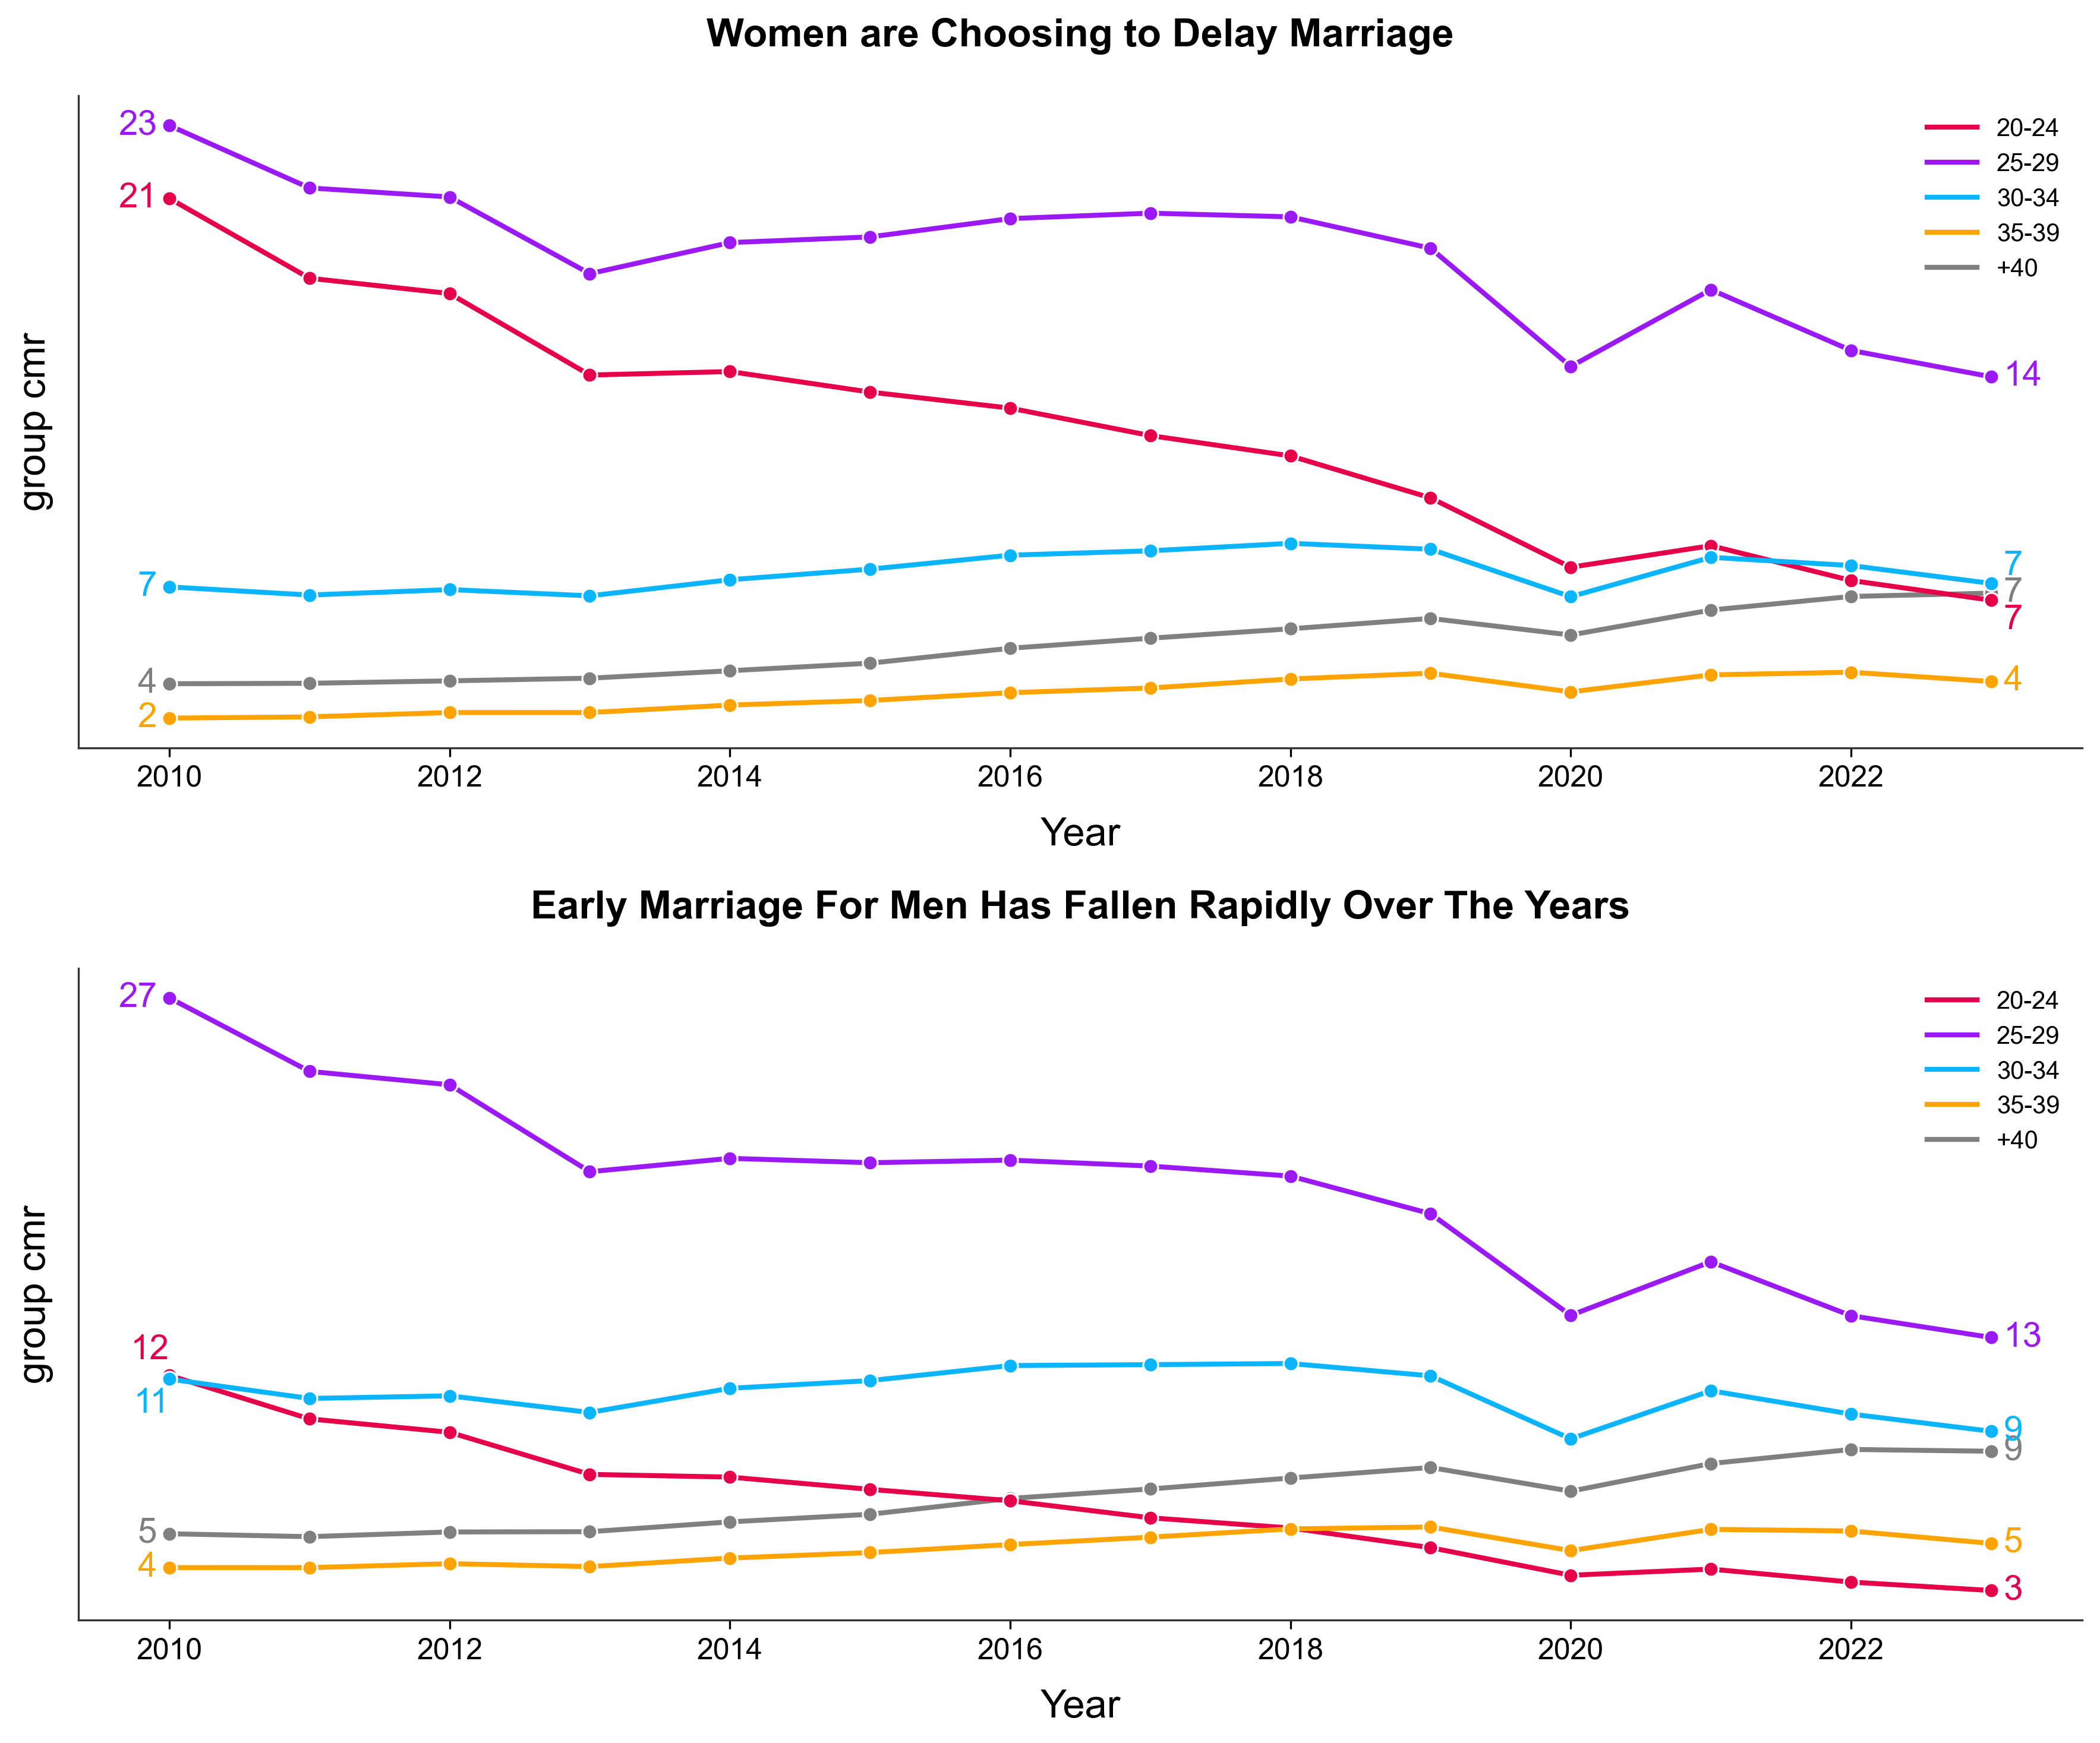

In [78]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
import matplotlib.ticker as mtick

for i, sex in enumerate(df_grouped_cmr['sex'].unique()):
    df_temp = df_grouped_cmr[(df_grouped_cmr['sex'] == sex) & (df_grouped_cmr['age group'] != '<20')]

    sns.lineplot(df_temp, x='Year', y='group cmr', ax=axes[i], hue='age group', marker='o', palette=custom_palette)

    handles, labels = axes[i].get_legend_handles_labels()
    
    order = [1,2,3,4,0] 
    axes[i].legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    axes[i].set_title(f'{"Women are Choosing to Delay Marriage" if sex == "female" else "Early Marriage For Men Has Fallen Rapidly Over The Years"}')
    axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))  # Assuming 'Value' is in the range [0, 1]
    
    for age_group in df_temp['age group'].unique():

        df_group = df_temp[df_temp['age group'] == age_group]
        last_row = df_group.iloc[-1]
        first_row = df_group.iloc[0]

        xy_pos_last = (5,0)
        xy_pos_first = (-5, 0)

        if sex == 'female':
            if age_group == '20-24':
                xy_pos_last = (5,-8)
            elif age_group == '30-34':
                xy_pos_last = (5,7)

        if sex == 'male':
            if age_group == '20-24':
                xy_pos_first = (0, 10)
            elif age_group == '30-34':
                xy_pos_first = (0, -10)

        last_text = axes[i].annotate("{:.0f}".format(last_row['group cmr']),
                         xy = (last_row['Year'],last_row['group cmr']),
                         xytext = xy_pos_last,
                         textcoords = 'offset points',
                         ha = 'left', 
                         va = 'center',
                         fontsize = 14,
                         color = custom_palette[age_group])
        
        first_text = axes[i].annotate("{:.0f}".format(first_row['group cmr']),
                         xy = (first_row['Year'], first_row['group cmr']),
                         xytext = xy_pos_first,
                         textcoords = 'offset points',
                         ha = 'right', 
                         va = 'center',
                         fontsize = 14,
                         color = custom_palette[age_group])
        
# Hide y-axis labels and spine if desired
for ax in axes:
    ax.set_yticks([])  # Remove tick marks
    ax.yaxis.set_ticks_position('none')  # Ensure no ticks are visible
plt.tight_layout()
plt.show()

#### Analysis
##### Women
For age groups 30-34 and 35-39, there is relatively minor change in the number of marriages within these age brackets, when compared to the changes in age brackets 20-24 and 25-29. For age group 20-24 the number of marriages has fallen by 66% and has fallen by 60% for age group 25-29 (while still remaining the most popular age bracket). Combining this with the overall decreasing CMR for Poland as a whole, we can see than the decrease in marriages in Poland is heavily the result of a drop in marriages by women of ages 20-29.

What is interesting however, is that there is no counterbalancing of marriages from ages 30-39. We can infer that there is likely a sociological factor in play here. As it has been noted, the value of marriage or traditional relationships has been shifting in the West, and moving toward valuing marriage less. There maybe a similar factor in play for young polish women, who potentially see less value in getting married young, or possibly at all. 

We can also see that marriages of women from ages 40+ have actually doubled over the past 14 years. 


##### Men
For men across all age groups, the trend heavily mirrors that of women as well. Marriages by men of ages 20-24 has fallen by 75% and has fallen by 50% for age group 25-29. And as in the case with women, marriages in the early and late thirties has remained relatively constant and marriages by those in their 40s or later has doubles since 2010.

# Findings
For our client we provided the insight:
* That the rate of marriage in Poland has been decreasing since 2008, and has begun to closely mirror those of Europe overall
* The decrease in marriages is heavily due to a decline in young men and women between ages 20-29 getting married
* Marriages by those in their 30's remains more or less constant through the years
* Marriages by those over the age of 40 has doubled.